# Using PyTorch feed forward NN to performe regression

## Import libraries and classes

In [53]:
import torch

import matplotlib.pyplot as plt
import numpy as np

from torch import nn, optim, tensor
from tqdm import tqdm
from Neural_Network_with_PyTorch import Neural_Network_PyTorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import linear_model
from copy import deepcopy

## Solving the regression problem

#### Generate data 

##### Support functions

In [54]:
def make_design_matrix(x, degree):
    "Creates the design matrix for the given polynomial degree and ijnput data"
    
    X = torch.zeros((len(x), degree+1))
    
    for i in range(X.shape[1]):
        X[:,i] = torch.pow(x, i)
        
    return X

In [55]:
torch.seed()

true_a = torch.tensor([2, 0.5, 3.2])

n = 1000

x = torch.linspace(0, 1, n).reshape(-1, 1)
target = ((torch.tensor([true_a[0] + true_a[1]*x + true_a[2]*x**2 for x in x]) + .5 * torch.randn(n)) * 1e-1).reshape(-1, 1)


print('Dimensions of design matrix:', x.shape)
print('Dimensions of target:', target.shape)

Dimensions of design matrix: torch.Size([1000, 1])
Dimensions of target: torch.Size([1000, 1])


Displaying the design matrix for the linear regression part. Further we need to split the data into training and test data. Lastly we display the target values in their respective groups.  

Creating the training and test data

In [56]:
train_X, test_X, train_target, test_target = train_test_split(x, target, test_size=0.2)

In [57]:
train_target = train_target.reshape(-1, 1)
test_target = test_target.reshape(-1, 1)

Displaying the target values in their respective groups

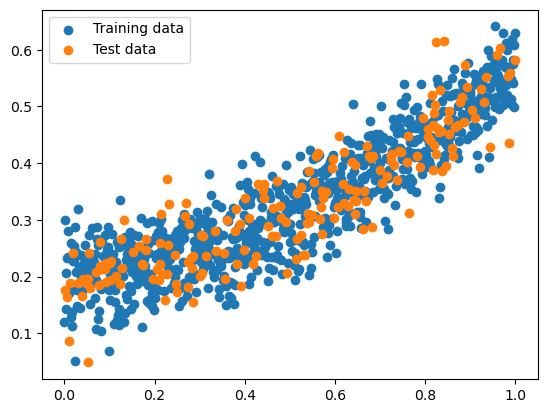

In [58]:
plt.figure()
plt.scatter(train_X[:,0], train_target, label='Training data')
plt.scatter(test_X[:,0], test_target, label='Test data')
plt.legend()

#### Initializing the model

We now initialize the model. We start with a randomly selected model architecture w.r.t. number of hidden layers, number of hidden nodes. For the input dimention we use the number of predictors from X i.e. the polynomial degree + 1 (for the intercept). For the output dimension we use the number of parameters in the true_a. For the activation function we use ReLU for the hidden layers and linear for the output layer, the latter is done since we are performing a regression analysis and not a classification.

In [59]:
# Network design
n_inputs = train_X.shape[1]
n_hidden_layers = 2
n_hidden_nodes = 4
n_outputs = 1

# Create network
ffnn = Neural_Network_PyTorch(n_inputs, 
                              n_hidden_layers, n_hidden_nodes, 
                              n_outputs, 
                              activation_function_hidden_layers='sigmoid', # ReLU activation function for hidden layers, more efficient and robust than sigmoid
                              activation_function_output_layer=None) # Linear activation function for output layer since we are doing regression

print('Model parameters:')
print(ffnn.hidden0)
print(ffnn.activation0)
print(ffnn.hidden1)
print(ffnn.activation1)
print(ffnn.linear_output)
print(ffnn.activated_output)

<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000024480287CE0>
Model parameters:
Linear(in_features=1, out_features=4, bias=True)
Sigmoid()
Linear(in_features=4, out_features=4, bias=True)
Sigmoid()
Linear(in_features=4, out_features=1, bias=True)
<function Neural_Network_PyTorch.set_activation_function.<locals>.dummy at 0x0000024480287CE0>


We now have to initiate the cost and the optimizer. We use linear_output)he mean squared error as cost function and the Adam optimizer.

In [60]:
criterion = nn.MSELoss()
optimizer = optim.Adam(ffnn.parameters(), lr=0.01)

#### Training the model

We now train the model. We use the training data to train the model. We use the mean squared error as cost function and the Adam optimizer. We train the model for 1000 epochs and use a batch size of 100.
Resourses: 
- https://machinelearningmastery.com/building-a-regression-model-in-pytorch/

In [76]:
num_epochs = 100
batch_size = 100

Further we note that it is note that it is note the true a's we are after in this instance as we were for the linear regression part. We are after the weights and biases of the neural network. 

In [77]:
iter = 0
loss_history = []
r2_history = []
best_mse = np.inf

for epoch in tqdm(range(num_epochs)):
    ffnn.train() # set the model to training mode
    for i in range(n//batch_size):
        # create mini batch
        start = i*batch_size
        end = start + batch_size
        batch_X = train_X[start:end]
        batch_target = train_target[start:end]
        
        # Zero the gradients
        optimizer.zero_grad()    

        # Forward pass to get output/logits
        mini_batch_target_pred = ffnn.feed_forward(batch_X)
    
        # Calculate loss and do backpropagation
        loss = criterion(mini_batch_target_pred, batch_target)
        loss_history.append(float(loss.item()))
        loss.backward()
    
        # Updating neural network parameters: weigths
        optimizer.step()    
       
        # ready for next iteration
        optimizer.zero_grad() # Clear gradients
        iter += 1     

100%|██████████| 100/100 [00:11<00:00,  8.86it/s]


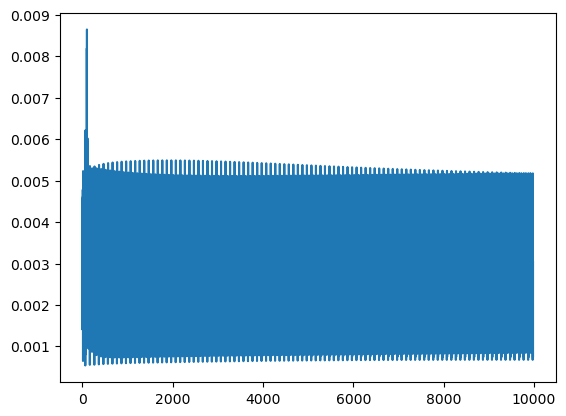

In [78]:
plt.plot(loss_history)

#### Testing model prediction

In [79]:
ffnn.eval() # set the model to evaluation mode  
with torch.no_grad(): # disable gradient computation

    predictions = ffnn.feed_forward(test_X)
    NN_test_mse = float(criterion(predictions, test_target))
    #loss_history.append(mse)
    NN_test_r2 = r2_score(test_target, predictions)
    #r2_history.append(r2)
    #if mse < best_mse:
    #    best_mse = mse
    #    best_weights = deepcopy(ffnn.state_dict())    
    #    epoch_best_mse = epoch

In [80]:
print(NN_test_mse)
print(NN_test_r2)

0.002512666629627347
0.8064379442243114


Perform OLS regression for comparison

In [81]:
OLS = linear_model.LinearRegression()
OLS.fit(train_X, train_target)
OLS_pred = OLS.predict(test_X)

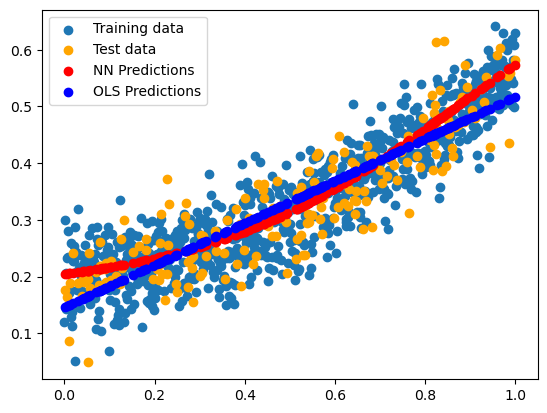

In [82]:
plt.figure()
plt.scatter(train_X[:,0], train_target, label='Training data')
plt.scatter(test_X[:,0], test_target, color='orange', label='Test data')
plt.scatter(test_X[:,0], predictions, color='red', label='NN Predictions')
plt.scatter(test_X[:,0], OLS_pred, color='blue', label='OLS Predictions')
plt.legend()

In [83]:
from sklearn.metrics import mean_squared_error

In [84]:
print(f'NN MSE: ', NN_test_mse)
print(f'OLS MSE: ', mean_squared_error(OLS_pred, test_target))

print('NN R2 score: ', NN_test_r2)
print('OLS R2 score:' , r2_score(OLS_pred, test_target))

NN MSE:  0.002512666629627347
OLS MSE:  0.002785807
NN R2 score:  0.8064379442243114
OLS R2 score: 0.7510042159977953


We see that, even for this randomly selected model architecture, the NN performs similar to the OLS regression. The advantage linked to the NN compared to regression will be further amplified when we move to more complex datasets with more intertwined relations.

# Model evaluation: Model selection and tuning

The nature of the neural network models is one of high number of unknown parameters. Assuming that there are a true *best parameter* for each task this leads to a high demand for parameter tuning. In the case of 1D regression we have a training process with low computational cost allowing us to perform a grid search for the optimal parameters, rather than a random search. (figure 11.2 (p.421) in the book).

When it comes to variables where we, as the practitionars, have a deciding point we have the following factors/tunable features (not neccesaraly ordered by importance):
**Hyper-Parameters of the Model and Training Criterion:**
- Number of hidden layers
- Number of nodes in each hidden layer
- Regularization with weight decay
    - L1
    - L2
- Weight and bias initialization
- Activation function for hidden layers (output layer is linear in the regression task)


**Training spesific support features:**
- Optimizer
    - Learning rate
        - Learning rate decay
    - Momentum
    - other hyperparameters

- Parameters connected to iterations
    - Number of epochs
    - Batch size
    - number of training iterations
        - early stopping
- Other Regularization terms
    - Dropout

**Other:**
- Cost function 
- Data preprocessing
- Seeds

In order to tie their importance back to the model we have to remind ourselves with the actual task requirments:
> The task is to predict the value of a continuous variable given a set of predictors.
> We which to meet this task by deep learning in our neural network model based on a training set.
> The tuned model should be able to generalize to unseen data that is assumed to be described by the same function. 

We will therefor assess the learning algorithm based on ability to:
1. Make the training error small (dlbook p. 108): Here we asses the models ability to fit the training data using a *cost function*.
2. Make the gap between training and test error small (dlbook p. 108): Here we asses the models ability to generalize to unseen data using a *cost function*.

And so, the consequences of our feature selection is if wrongfully chosen we might end up with a model that is not able to generalize to unseen data. Following that tread; in order to get a model that is not overfitted and that leaves the test set unseen we will perform the model tuning on a validation set generated from the training set. This is done by splitting the training set into a training set and a validation set in a 80/20 split. Further, since samples is not scarce for our vanilla datasets we will not use k-fold cross validation but rather a straight forward training.

In the following sections we will investigate and account for the different features and their importance for the model.

## Set up data for model hyperparameter tuning, training and test prediction

In [22]:
torch.seed()

true_a = torch.tensor([2, 0.5, 3.2])

n = 1000

x = torch.linspace(0, 1, n)
target = ((torch.tensor([true_a[0] + true_a[1]*x + true_a[2]*x**2 for x in x]) + .5 * torch.randn(n)) * 1e-1).reshape(-1, 1)

# Making a design matrix to use for linear regression part
degree = 2
X = make_design_matrix(x, degree)

train_X, test_X, train_target, test_target = train_test_split(X, target, test_size=0.2)
train_X, val_X, train_target, val_target = train_test_split(train_X, train_target, test_size=0.2)

train_target = train_target.reshape(-1, 1)
test_target = test_target.reshape(-1, 1)
val_target = val_target.reshape(-1, 1)

Display data split:

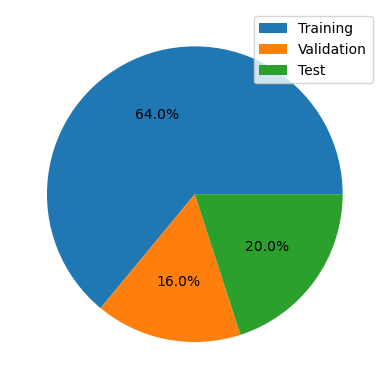

In [39]:
dataset = {'Training': train_X.shape[0],
           'Validation': val_X.shape[0], 
           'Test': test_X.shape[0]} 

plt.figure()
plt.pie(dataset.values(), autopct='%1.1f%%')
plt.legend(dataset.keys())
plt.show()

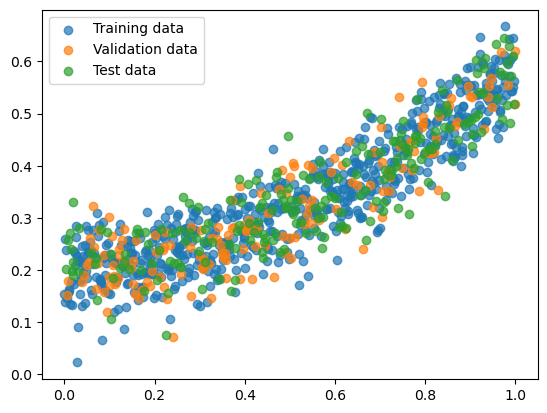

In [41]:
plt.figure()
plt.scatter(train_X[:,1], train_target, label='Training data', alpha=0.7)
plt.scatter(val_X[:,1], val_target, label='Validation data', alpha=0.7)
plt.scatter(test_X[:,1], test_target, label='Test data', alpha=0.7)
plt.legend()

## Model architecture

In a neural network the *capacity* of the model is determined by the model architecture. Here we refer to capacity as the ability to learn complex relations leading to a correct mapping. Some examples (with informal notation) are: $X \mapsto \{True, False\} / \{0, 1\}$ or $X \mapsto \mathbf{y}\in\mathbb{R}$ where $\mapsto$ denotes "*maps to*". 

In general, the learning algorythm will, under our assessment criterions perform better with a model capacity mathched with the complexity of the task (dlb). From this the questions arises: what if there is a mismatch? 
- In the case of a model with too low capacity, the model will not be able to learn the task. This is refeered to as *underfitting*.  
- In the case of a model with too high capacity, the model will be able to learn the task, but will not be able to generalize to unseen data. This is refeered to as *overfitting*.

We can identify the model capacity by assessment criterion 2. "how large is the gap between the training and the test error?".

### Number of hidden layers and nodes

One way to increase the model capacity is to increase the number of hidden layers. Even tho we by the "... approximation theorem" strictly can learn the relations by one layer only with many nodes, we might need more layers to learn the relations with higher accuracy. And so, the need for a high number of hidden layers is not a given, but should be investigated in parallell with the number of nodes in each layer. This means that this is a matter of tuning the model architecture depending on the model complexity. 


### Activation functions

The role of the activation function is discussed in ... . The activation function for the output layer is linear since we are performing a regression task. Further when we look at the activation function for the hidden layers we have a choice between sigmoid and ReLU. We choose here the ReLU activation function without investigating the performance. This is because the ReLU function is more robust since it does not suffer from the vanishing gradient problem. Further it is more efficient since it is computationally less expensive as a result from the section wise linearity.

## Training specific support features

### Cost function

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

During training we assess the performance of the model by the cost function. This quantification of the error sets the direction of model adjustment and so a wrongfull selection of cost function, might reduce the prediction ability of the NN. It is therefor of high importance to know the data and the task at hand, before selecting the cost function. In our case the task at hand is a regression task. Further we know that the mean will be a good measure of central tendency for the errors since the errors are indeed generated around a standard normal distribution. We will therefor use the *mean* squared error as cost function. If we, while investigating a tru dataset found a skewed distribution of the errors the MSE might not be the best selection for cost function. Then the selection will be partly dictated by our which to favour outliers or not. If we do not wish to favour outliers we might use the *median* as better measure of central tendency. And choose cost functions accordingly. 

To conclude: we again choose the MSE as cost function since we know the errors are generated around a standard normal distribution.

In [21]:
criterion = nn.MSELoss()

### Optimizer

The optimizer is the algorithm that performs the gradient descent in the NN backpropagation. As displayed in a) we saw that the gradient descent is performed in steps towards the minimum of the cost function. 

The two most widely used optimizers is the Adam and the SGD with Nesterov momentum. We will use the Adam optimizer throughout our PyTorch implementation of the NN. The adam optimizer is an adaptive optimizer, meaning that it adapts the learning rate during training. This is done by using the first and second moments of the gradients. The first moment is the mean of the gradients and the second moment is the uncentered variance of the gradients. The Adam optimizer uses these moments to adapt the learning rate. The Adam optimizer is therefor more efficient than the SGD in most applications. 
https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#:~:text=Adam%20is%20an%20optimization%20algorithm%20that,weights%20iterative%20based%20in%20training%20data.&text=Adam%20is%20an%20optimization,based%20in%20training%20data.&text=an%20optimization%20algorithm%20that,weights%20iterative%20based%20in 

https://arxiv.org/abs/1412.6980
https://arxiv.org/abs/1609.04747

This optimizer still has some hyperparameters to be tuned. Here under we have the learning rate, $\beta_1$, $\beta_2$ and $\varepsilon$. We will only perform configuration of the learning rate as it has the largest impact on the performance of the optimizer. The other hyperparameters are set to their default values suggested in https://arxiv.org/abs/1412.6980. 



### Number of epochs and batch size

The number of epocs refeers to the number of times we pass through the entire dataset. For our purposes we will set this to 100. The significance of the number of epochs is that it governs the number of times we perform the backpropagation. Thus it also governs the training quality as well as the computational cost.

The batch size governs more interesting effects. https://github.com/google-research/tuning_playbook#choosing-the-batch-size
If one changes the batch size one will have to re-tune other parameters. This is because; a change in batch size changes the number of samples available for training effecting the interaction between data and optimizers hyperparameters through the costs. 

   

## Grid search for the "untuned" features. 

#### Investigating NN architecture: number of hidden layers and nodes grid search

Let us perform a grid search with confined to hidden layers in the set $\{1, 2, 3\}$ and nodes in each layer in the set $\{2, 4, 8, 16\}$. We will use the same training parameters as done in the previous section.

In [ ]:
def train_NN(train_X, train_target, num_epochs, batch_size, ffnn, criterion, optimizer):
    loss_history = []
    iter = 0
    for epoch in tqdm(range(num_epochs)):
            ffnn.train() # set the model to training mode
            for i in range(n//batch_size):
                # create mini batch
                start = i*batch_size
                end = start + batch_size
                batch_X = train_X[start:end]
                batch_target = train_target[start:end]
                
                # Zero the gradients
                optimizer.zero_grad()    
        
                # Forward pass to get output/logits
                mini_batch_target_pred = ffnn.feed_forward(batch_X)
            
                # Calculate loss and do backpropagation
                loss = criterion(mini_batch_target_pred, batch_target)
                loss_history.append(float(loss.item()))
                loss.backward()
            
                # Updating neural network parameters: weigths
                optimizer.step()    
               
                # ready for next iteration
                optimizer.zero_grad() # Clear gradients
                iter += 1 
        
    return loss_history
    

In [20]:
num_epochs = 100
batch_size = 100

n_hidden_layers_set = [1, 2, 3]
n_hidden_nodes_set = [2, 4, 8, 16]

model_architectures = []

for n_hidden_layers in n_hidden_layers_set:
    for n_hidden in n_hidden_nodes_set:
        ffnn = Neural_Network_PyTorch(n_inputs, 
                                      n_hidden_layers, n_hidden, 
                                      n_outputs, 
                                      activation_function_hidden_layers='ReLU', # ReLU activation function for hidden layers, more efficient and robust than sigmoid
                                      activation_function_output_layer=None) # Linear activation function for output layer since we are doing regression
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(ffnn.parameters(), lr=0.01)
        
        train_NN(train_X, train_target, num_epochs, batch_size, ffnn, criterion, optimizer)
        
        ffnn.eval() # set model in evaluation mode
        with torch.no_grad(): # disable gradient computation
            predictions = ffnn.feed_forward(test_X)
            NN_test_mse = float(criterion(predictions, test_target))
            NN_test_r2 = r2_score(test_target, predictions)
        model_dict = {
        'model': ffnn,  # store the model instance
        'model_state_dict': ffnn.state_dict(),  # store the state_dict of the model
        'optimizer_state_dict': optimizer.state_dict(),  # store the state_dict of the optimizer
        'Training MSE': loss_history[-1], # store the final training MSE
        'Test MSE': NN_test_mse, # store the test MSE
        'Test R2': NN_test_r2 # store the test R2
        }
        
        model_architectures.append(model_dict)
        

SyntaxError: incomplete input (2294371336.py, line 51)

## Training specific support features

### Cost function

# Investigating NN architecture: number of hidden layers and nodes

Until now we have seen the results of a randomly selected model architecture. We now want to tune the model architecture to see if we can improve the results. We will do this by using a grid search to tune 